In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pymongo import MongoClient
from time import sleep
import folium

# Connect to MongoDB
host_ip = "192.168.0.116"
client = MongoClient(host_ip, 27017)
db = client.fit3182_a2_db






120.0


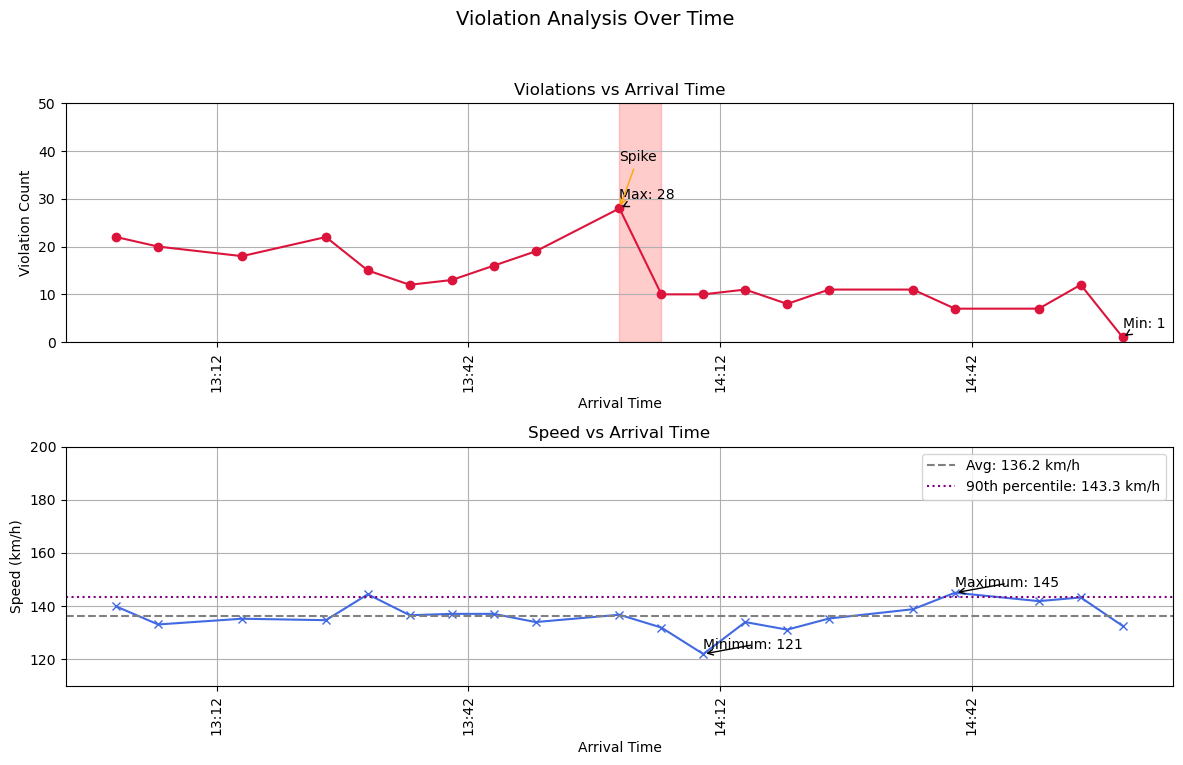

In [97]:
def init_dual_plots(interval_minutes=1):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle("Violation Analysis Over Time", fontsize=14)

    time_formatter = mdates.DateFormatter('%H:%M')
    time_locator = mdates.MinuteLocator(interval=interval_minutes)

    for ax, ylabel in zip(axs, ["Violation Count", "Speed (km/h)"]):
        ax.set_xlabel("Arrival Time")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.xaxis.set_major_formatter(time_formatter)
        ax.xaxis.set_major_locator(time_locator)
        ax.tick_params(axis='x', rotation=90)

    axs[0].set_title("Violations vs Arrival Time")
    axs[0].set_ylim(0, 50)

    axs[1].set_title("Speed vs Arrival Time")
    axs[1].set_ylim(110, 200)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axs

def plot_graph():
    
    violations_db = db.violations

    # Load data from MongoDB into a DataFrame
    violations_pd = pd.DataFrame(list(violations_db.find()))

    if violations_pd.empty:
        print("No data found in violations collection.")
        return

    # Convert timestamp to datetime
    violations_pd['timestamp_end'] = pd.to_datetime(violations_pd['timestamp_end'])
    violations_pd['time_bin'] = violations_pd['timestamp_end'].dt.floor('5min') # round down the nearest min
    
    
    # Group by the bins specified
    grouped = violations_pd.groupby('time_bin').agg({
        'speed_reading': 'mean', # get the mean
        'timestamp_end': 'count' # get the all the timstamps which fall under the same time_bin and that would be the number of violations in the time_bin
    }).rename(columns={'timestamp_end': 'violation_count'})


    if grouped.empty:
        print("No data available after grouping.")
        return
    
    
#     filter time range
    # Define time range (modify these as needed)
    start_filter = pd.to_datetime("2024-01-01 13:00:00")
    end_filter = pd.to_datetime("2024-01-01 15:00:00")

    # Apply filter to the grouped DataFrame
    grouped = grouped.loc[(grouped.index >= start_filter) & (grouped.index <= end_filter)]
    

    # Calculate dynamic interval
    start_time = grouped.index.min()
    end_time = grouped.index.max()
    total_minutes = (end_time - start_time).total_seconds() / 60

    print(total_minutes)
    if total_minutes <= 60:
        interval = 10
    elif total_minutes <= 180:
        interval = 30
    elif total_minutes <= 720:
        interval = 60
    else:
        interval = 200

    # Initialize plots
    fig, axs = init_dual_plots(interval_minutes=interval)

    # Plot data
    axs[0].plot(grouped.index, grouped['violation_count'], marker='o', color='crimson')# Plotting the grouped time intervals on the x-axis and the number of violations per interval on the y-axis
    axs[1].plot(grouped.index, grouped['speed_reading'], marker='x', color='royalblue')

    # Annotate max violation count
    max_violation_time = grouped['violation_count'].idxmax()
    max_violation_value = grouped['violation_count'].max()
    axs[0].annotate(f'Max: {max_violation_value}',
                    xy=(max_violation_time, max_violation_value),
                    xytext=(max_violation_time, max_violation_value + 2),
                    arrowprops=dict(facecolor='red', arrowstyle='->'))
    
    # Annotate the min violation count
    min_violation_time = grouped['violation_count'].idxmin()
    min_violation_value = grouped['violation_count'].min()
    axs[0].annotate(f'Min: {min_violation_value}',
                    xy=(min_violation_time, min_violation_value),
                    xytext=(min_violation_time, min_violation_value + 2),
                    arrowprops=dict(facecolor='red', arrowstyle='->'))
    
    
    # Annotate lowest speed violation
    min_speed_time = grouped['speed_reading'].idxmin() # get the lowest time
    min_speed_value = grouped['speed_reading'].min() # get the lowest value
    axs[1].annotate(f'Minimum: {int(min_speed_value)}',
                    xy=(min_speed_time, min_speed_value),
                    xytext=(min_speed_time, min_speed_value + 2),
                    arrowprops=dict(facecolor='purple', arrowstyle='->'))
    
    
    # Annotate the highest speed violation
    max_speed_time = grouped['speed_reading'].idxmax() # get the lowest time
    max_speed_value = grouped['speed_reading'].max() # get the lowest value
    axs[1].annotate(f'Maximum: {int(max_speed_value)}',
                    xy=(max_speed_time, max_speed_value),
                    xytext=(max_speed_time, max_speed_value + 2),
                    arrowprops=dict(facecolor='purple', arrowstyle='->'))
    
    
    # find sudden drops
    grouped['violation_diff'] = grouped['violation_count'].diff() # find the difference between consecutive rows of violation_count column
    
    # Shaded region for high violation difference
    high_violation = grouped[grouped['violation_diff'] > 5] # adjust the threshold
    for time_bin in high_violation.index:
        axs[0].axvspan(time_bin, time_bin + pd.Timedelta(minutes=5), color='red', alpha=0.2)
        
    # Spikes
    spikes = grouped[grouped['violation_diff'] > 5]
    for idx, row in spikes.iterrows():
        axs[0].annotate("Spike", xy=(idx, row['violation_count']),
                        xytext=(idx, row['violation_count'] + 10),
                        arrowprops=dict(arrowstyle='->', color='orange'))
    

    # Draw average speed line
    avg_speed = grouped['speed_reading'].mean()
    axs[1].axhline(avg_speed, color='gray', linestyle='--', label=f'Avg: {avg_speed:.1f} km/h')
    
    
    # Draw the 90th percentile
    percentile_90 = grouped["speed_reading"].quantile(0.9)
    axs[1].axhline(percentile_90, color='purple', linestyle=':', label=f'90th percentile: {percentile_90:.1f} km/h')
    axs[1].legend()
    plt.show()

plot_graph()
    


    


In [98]:
# Initialise the map position
fomap = folium.Map(location=[2.162418757, 102.6601002], zoom_start=15)

# Load camera data
cameras_db = db.camera
cameras_list = list(cameras_db.find())
sorted_cameras = sorted(cameras_list, key=lambda cam: cam['position'])

# Load violation data
violations_db = db.violations
violations_pd = pd.DataFrame(list(violations_db.find()))

# Group by start, end, and type
grouped = violations_pd.groupby(
    ['camera_id_start', 'camera_id_end', 'violation_type']
).agg({
    'violation_type': 'count'
}).rename(columns={'violation_type': 'violation_count'}).reset_index()

# Split grouped data by type
instantaneous_group = grouped[grouped['violation_type'] == 'instantaneous']
average_group = grouped[grouped['violation_type'] == 'average']

# Create lookup dictionaries
instantaneous_counts = instantaneous_group.set_index('camera_id_start')['violation_count'].to_dict()
average_counts = average_group.set_index(['camera_id_start', 'camera_id_end'])['violation_count'].to_dict()

# Init map centered around first camera
first_cam = sorted_cameras[0]
fomap = folium.Map(location=[float(first_cam['latitude']), float(first_cam['longitude'])], zoom_start=15)

# Add camera markers and collect coordinates
camera_coords = []
camera_id_sequence = []

for cam in sorted_cameras:
    lat = float(cam['latitude'])
    lon = float(cam['longitude'])
    cam_id = int(cam['camera_id'])
    inst_count = instantaneous_counts.get(cam_id, 0)

    camera_coords.append((lat, lon))
    camera_id_sequence.append(cam_id)

    popup_text = f"Camera {cam_id}<br>Instantaneous Violations: {inst_count}"

    folium.Marker(
        location=(lat, lon),
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color='blue', icon='camera')
    ).add_to(fomap)

# Draw lines between consecutive camera pairs with average violations
for i in range(len(camera_coords) - 1):
    cam_start = camera_id_sequence[i]
    cam_end = camera_id_sequence[i + 1]
    avg_count = average_counts.get((cam_start, cam_end), 0)

    tooltip_text = f"Camera {cam_start} → {cam_end}<br>Average Violations: {avg_count}"

    folium.PolyLine(
        locations=[camera_coords[i], camera_coords[i + 1]],
        color='purple',
        weight=3 + min(avg_count // 10, 5),  # thicker line for higher counts
        opacity=0.7,
        tooltip=folium.Tooltip(tooltip_text)
    ).add_to(fomap)

In [96]:
fomap